In [258]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [259]:
torch.manual_seed(0)
np.random.seed(0)

In [260]:
INPUT_WINDOW = 50 # number of input steps
output_window = 50 # number of prediction steps, in this model its fixed to one
block_len = INPUT_WINDOW + output_window # for one input-output pair
batch_size = 64
TRAIN_SIZE = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_FEATURES = 7
WRITE_TO_TENSORBOARD = False
SHUFFLE = True
RUN_NAME = f"1-9-2024 2lstm_conv r2 loss {INPUT_WINDOW}, outwin: {output_window}"
SCALE_DATA = True


In [261]:
def create_inout_sequences(input_data, INPUT_WINDOW ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1
    # where block_len = INPUT_WINDOW + output_window
    for i in range( block_num ):
        if input_data.iloc[i]["vid_id"] == input_data.iloc[i + INPUT_WINDOW - 1]["vid_id"]:
            train_seq = input_data[i : i + INPUT_WINDOW]
            train_label = input_data[i + output_window : i + INPUT_WINDOW + output_window]
            inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))

In [262]:
# EXERCISE = "squat"
# SLICE = "yes"
# # def get_data():

# angles = pd.read_csv("data/angles.csv")
# labels = pd.read_csv("data/labels.csv")

# # get data only for a single exercise
# if SLICE == "yes":
#     labels = labels[labels["class"]==EXERCISE]
#     angles = angles[angles["vid_id"].isin(labels["vid_id"])]
# # plt.plot(angles[angles["vid_id"] == 385].iloc[:,8].rolling(window=10).mean())
# # plt.plot(angles[angles["vid_id"] == 412].iloc[:,4].rolling(window=3).mean().diff().dropna())
# scaler = MinMaxScaler(feature_range=(0, 1))
# angles_to_scale = angles.iloc[:,2:]
# scaled_angles = pd.DataFrame(scaler.fit_transform(angles_to_scale))
# # scaled_angles = angles

# if SCALE_DATA == True:
#     angles = pd.concat([angles.iloc[:,0:2].reset_index(drop=True), scaled_angles.reset_index(drop=True)], axis=1)
# sequences = create_inout_sequences(angles, INPUT_WINDOW, output_window)

# # shuffling sequences
# if SHUFFLE == True:
#     shuffled_indices = torch.randperm(sequences.size(0))
#     sequences = sequences[shuffled_indices]

# sequences = sequences[:,:,:,2:]
# samples = int(len(sequences) * TRAIN_SIZE) # use a parameter to control training size

# train_sequence = sequences[:samples]
# test_sequence = sequences[samples:]

# #     return train_sequence.to(device),test_sequence.to(device), scaler

# # train_data, val_data, scaler= get_data()

In [263]:
# plt.figure(figsize=(20,10))
# plt.plot(angles.iloc[:,8].rolling(100).mean())

In [264]:
# plt.plot(pd.DataFrame(train_sequence[][0][:,1]).rolling(window=10).mean())

In [265]:
EXERCISE = "squat"
SLICE = "yes"
def get_data():

    angles = pd.read_csv("data/angles.csv")
    labels = pd.read_csv("data/labels.csv")

    # get data only for a single exercise
    if SLICE == "yes":
        labels = labels[labels["class"]==EXERCISE]
        angles = angles[angles["vid_id"].isin(labels["vid_id"])]

    scaler = MinMaxScaler(feature_range=(0, 1))
    angles_to_scale = angles.iloc[:,2:]
    scaled_angles = pd.DataFrame(scaler.fit_transform(angles_to_scale))
    # scaled_angles = angles
    if SCALE_DATA == True:
        angles = pd.concat([angles.iloc[:,0:2].reset_index(drop=True), scaled_angles.reset_index(drop=True)], axis=1)
    sequences = create_inout_sequences(angles, INPUT_WINDOW, output_window)

    # shuffling sequences
    if SHUFFLE == True:
        shuffled_indices = torch.randperm(sequences.size(0))
        sequences = sequences[shuffled_indices]

    sequences = sequences[:,:,:,2:]
    samples = int(len(sequences) * TRAIN_SIZE) # use a parameter to control training size

    train_sequence = sequences[:samples]
    test_sequence = sequences[samples:]

    return train_sequence.to(device),test_sequence.to(device), scaler

train_data, val_data, scaler= get_data()

In [266]:
# col = 3
# plt.plot(train_data[0][0][:,col])
# plt.plot(pd.DataFrame(train_data[0][0][:,col]).diff().dropna())

# train_data[0][0][:,1].shape

In [267]:
    # TODO: getting the viz done right
    # num = 50
    # seq = train_sequence[num][0][:, 3]
    # # Convert train_data to NumPy if necessary
    # train_data_np = train_data.values if isinstance(train_data, pd.DataFrame) else train_data
    # subset_np = seq.numpy() if hasattr(seq, 'numpy') else seq

    # # Indices for the subset within train_data
    # start_index = num  # Adjust this index based on the position of train_sequence[0][0][:,3] within train_data
    # end_index = start_index + len(subset_np)

    # # Plot the entire train_data
    # plt.figure(figsize=(25,10))
    # plt.plot(train_data_np[:, 3], label='train_data', color='blue')

    # # Highlight the subset
    # plt.plot(range(start_index, end_index), subset_np, label='Highlighted Subset', color='red')
    # # Additional plot settings
    # plt.xlabel('Index')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.title('Highlighting a Subset within train_data')
    # plt.show()

In [268]:
def get_batch(input_data, i, batch_size):
    batch_len = min(batch_size, len(input_data) - i)
    
    # Extract the input and target tensors from the batch
    data = input_data[i:i + batch_len]
    
    # Extracting the inputs and targets
    inputs = torch.stack([item[0] for item in data]) # Shape: [100, batch_len, 9]
    targets = torch.stack([item[1] for item in data])  # Shape: [100, batch_len, 9]
    
    return inputs, targets

In [269]:
class MyNN(nn.Module):
    
    def __init__(self, num_classes=7, input_size=7, hidden_size=64, num_layers=2):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linera_relu_stack = nn.Sequential(
            nn.Linear(7, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,7)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linera_relu_stack(x)
        return logits
    
# model = LSTM().to(device)
# summary(model, (10,7))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming the input has a sequence length of 10 and input size of 7
sequence_length = 10
input_size = 7
model = MyNN().to(device)
# summary(model, (batch_size, sequence_length, input_size))

In [270]:
# FROM COLAB
input_window = INPUT_WINDOW
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=NUM_FEATURES, hidden_size=64, num_layers=1, batch_first=True)
        self.gru = nn.GRU(input_size=NUM_FEATURES, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.d1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(input_window*64, 512)
        self.d2 = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, input_window*NUM_FEATURES)
        self.conv = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3, padding=1)
        # self.view
        self.lstm2 = nn.LSTM(input_size=NUM_FEATURES, hidden_size=48, num_layers=1, batch_first=True)
        self.fc3 = nn.Linear(input_window*48, input_window*NUM_FEATURES)

    def forward(self,x):
        x , (h_n1, c_n1) = self.lstm1(x)
        # x ,_= self.gru(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.fc1(x)
        x = self.d2(x)
        x = self.fc2(x)
        x = x.view(x.size(0), input_window, NUM_FEATURES)
        # print(x.shape)
        x, (h_n2, cn_2) = self.lstm2(x)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc3(x)
        x = x.view(x.size(0), input_window, NUM_FEATURES)
        return x

lstm_model = LSTMModel().to(device)
# summary(lstm_model, (10,9))

sample_input = torch.randn(batch_size,input_window, NUM_FEATURES).to(device) # input should be (batch_size, seq_len(input_window(t)), num_features)
output= lstm_model(sample_input)
# print(len(output[0]))
print(output.shape)

torch.Size([64, 50, 7])


In [271]:
# class LSTMModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lstm1 = nn.LSTM(input_size=NUM_FEATURES, hidden_size=64, num_layers=1, batch_first=True)
#         # self.lstm2 = nn.LSTM(input_size=32, hidden_size=48, num_layers=1, batch_first=True)
#         self.flatten = nn.Flatten()
#         self.d1 = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(INPUT_WINDOW*64, 512)
#         self.d2 = nn.Dropout(0.3)
#         # self.batch_norm = nn.BatchNorm1d(num_features=320)
#         self.fc2 = nn.Linear(512, INPUT_WINDOW*NUM_FEATURES)
#         self.conv = nn.Conv1d(in_channels=INPUT_WINDOW, out_channels=INPUT_WINDOW, kernel_size=3, padding=1)

#     def forward(self,x):
#         x , (h_n, c_n) = self.lstm1(x)
#         # x , (h_n, c_n) = self.lstm2(x)
#         x = self.flatten(x)
#         x = self.d1(x)
#         x = self.fc1(x)
#         x = self.d2(x)
#         x = self.fc2(x)
#         x = x.view(x.size(0), INPUT_WINDOW, NUM_FEATURES)
#         x = self.conv(x)
#         return x
    
# lstm_model = LSTMModel().to(device)
# # summary(lstm_model, (10,9))

# sample_input = torch.randn(batch_size,INPUT_WINDOW, NUM_FEATURES).to(device) # input should be (batch_size, seq_len(INPUT_WINDOW(t)), num_features)
# output= lstm_model(sample_input)
# # print(len(output[0]))
# print(output.shape)

In [272]:
MODEL = lstm_model
if WRITE_TO_TENSORBOARD == True:

    # Set a unique name for your run
    log_dir = f"runs/{RUN_NAME}"

    # Initialize SummaryWriter with the custom log directory
    writer = SummaryWriter(log_dir=log_dir, comment="increased lstm layers from 1 to 2")
    writer.add_graph(lstm_model, torch.rand([batch_size,INPUT_WINDOW, NUM_FEATURES]))

In [273]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    # print("sstot={:3.3f} | ssres={:3.3f} | r2={:3.3f}".format(ss_tot,ss_res, r2))
    return 1 - r2

In [274]:
optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-3)
loss_fn = nn.HuberLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=1)

In [ ]:
def evaluate(eval_model, data_source, eval_batch_size):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * loss_fn(output, targets).cpu().item()
            # total_loss += len(data[0]) * r2_loss(output, targets).cpu().item()
    return total_loss / len(data_source)

In [276]:
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-INPUT_WINDOW:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)

In [ ]:
def train(model, train_data, optimizer, loss_fn, epoch):
    model.train()
    start_time = time.time()
    total_loss = 0
    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (INPUT_WINDOW,batch_len,1)
        # print(train_data.shape)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        # print(data.shape)
        output = model(data)
        # loss = loss_fn(output, targets)
        loss = r2_loss(output, targets)
        if WRITE_TO_TENSORBOARD == True:
            writer.add_scalar("loss", loss, epoch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            # print(f"loss.item = {loss.item()}")
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.4f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            # print('| epoch {:3d} | {:5d}/{:5d} batches | '
            #       'lr {:02.6f} | {:5.2f} ms | '
            #       'loss {:5.5f}'.format(
            #         epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
            #         elapsed * 1000 / log_interval,
            #         loss.item()))
            total_loss = 0
            start_time = time.time()
        # break


In [ ]:

epochs = 100
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data=train_data, optimizer=optimizer, loss_fn=loss_fn, epoch=epoch, model=MODEL)
    if ( epoch % 5 == 0 ):
        predict_future(MODEL, val_data,batch_size)
    else:
        val_loss = evaluate(MODEL, val_data, batch_size)
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    # print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, (time.time() - epoch_start_time),
    #                                  val_loss))
    print('-' * 89)
    if WRITE_TO_TENSORBOARD == True:
        writer.add_scalar("val_loss", val_loss, epoch)
        
    scheduler.step() 

/home/tanmaymistry/miniconda3/envs/beproj/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:525: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   1 |    21/  109 batches | lr 0.001000 | 31.06 ms | loss 0.67530
| epoch   1 |    42/  109 batches | lr 0.001000 | 28.76 ms | loss 0.71119
| epoch   1 |    63/  109 batches | lr 0.001000 | 23.27 ms | loss 0.65399
| epoch   1 |    84/  109 batches | lr 0.001000 | 23.49 ms | loss 0.68065
| epoch   1 |   105/  109 batches | lr 0.001000 | 23.72 ms | loss 0.58388
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.95s | valid loss 0.49351
-----------------------------------------------------------------------------------------
| epoch   2 |    21/  109 batches | lr 0.001000 | 25.02 ms | loss 0.50842
| epoch   2 |    42/  109 batches | lr 0.001000 | 24.81 ms | loss 0.59106
| epoch   2 |    63/  109 batches | lr 0.001000 | 24.38 ms | loss 0.56581
| epoch   2 |    84/  109 batches | lr 0.001000 | 23.43 ms | loss 0.57689
| epoch   2 |   105/  109 batches | lr 0.001000 | 23.39 ms | loss 0.53821
-------------------------

In [284]:
inp, targets = get_batch(train_data, 0, batch_size)
output = MODEL(inp)
tinp, ttargets, toutput = inp.transpose(1,2), targets.transpose(1,2), output.transpose(1,2)
scaler.inverse_transform(targets[0])[0], scaler.inverse_transform(output[0].detach().numpy())[0]

(array([ 98.64796413, 121.22366344,  38.21436068, 121.33571273,
        114.10831925, 164.99077077, 129.7832336 ]),
 array([ 92.915215, 112.29022 ,  29.103252, 128.02917 , 115.98841 ,
        121.47767 , 131.55945 ], dtype=float32))

In [296]:
mse_loss = nn.MSELoss()
my_loss = mse_loss(output, targets)
my_loss
# when loss==mse(0.427): r2 = 0.8624 -8919 

tensor(0.0069, grad_fn=<MseLossBackward0>)

Text(0.5, 1.0, 'Highlighting a Subset within train_data')

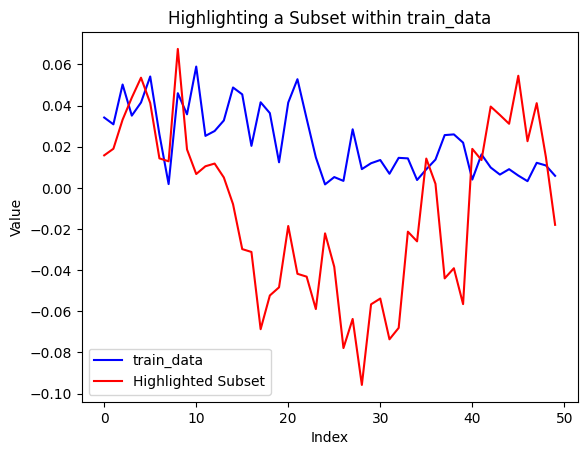

In [314]:

# Plot the entire train_data
pred_batch_num = 60
col_id = 0
# concat_data = torch.cat((tinp[pred_batch_num][col_id], ttargets[pred_batch_num][col_id]), dim=0)
plt.plot(ttargets[pred_batch_num][col_id], label='train_data', color='blue')
# plt.plot(concat_data, label='train_data', color='blue')

# Highlight the subset
plt.plot(toutput[pred_batch_num][col_id].detach().numpy(), label='Highlighted Subset', color='red')

# Additional plot settings
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Highlighting a Subset within train_data')

In [282]:
if WRITE_TO_TENSORBOARD == True:
    !tensorboard --logdir=runs

In [1]:
!tensorboard --logdir==runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [283]:
# # to be used for later use
# import os
# import pandas as pd
# from torchvision.io import read_image
# from torch.utils.data import Dataset

# class CustomImageDataset(Dataset):
#     def __init__(self, EXERCISE, annotations_file="data/labels.csv", data_file="data/angles.csv", SLICE="no", transform="yes"):
#         self.labels = pd.read_csv(annotations_file)
#         self.angles = pd.read_csv(data_file)
#         # self.data_file = data_file
#         if SLICE == "yes":
#             self.labels = self.labels[self.labels["class"]==EXERCISE]
#             self.angles = self.angles[self.angles["vid_id"].isin(self.labels["vid_id"])]
#         if transform == "yes":
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             self.angles1 = self.angles.drop(["vid_id","frame_order"], axis=1)
#             self.tangles = scaler.fit_transform(self.angles1)

#     def __len__(self):
#         return len(self.angles)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.data_file, self.labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label